### TODO:
- [x] latency summary에 추가하기
- [x] frame drop baseline performance 비교하는 figure 만들기; 기존 (using summary)
- [x] frame drop baseline들 backlog 증가 그래프 그리는 figure 만들기; 기존 (using data)
- [x] offloading baseline performance 비교하는 figure 만들기; fraction & accuracy & latency 비교; simulation에서 쓰던 형태 (using data & summary)
- [x] offloading baseline들 backlog 증가 그래프 그리는 figure 만들기; 기존 (using data)
- [ ] multi agent 성능 비교 하는 figure 만들기
- [ ] multi agent에서 각 source node의 backlog 증가 그래프 그려서 비교하기

### Import libraries

In [1]:
import os, sys, time, re, random
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns
import csv, json, ast  

In [2]:
### User define libraries
import visualization as vis
import warnings

warnings.filterwarnings("ignore")

### Define methods

In [3]:

def extract_value_from_latency(value_str):
    return float(value_str.split('ms')[0].strip())

def get_latency_exp(csv_path):
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        df['latency'] = df['latency'].apply(extract_value_from_latency)
        return df
        
def get_backlog_exp(csv_path):
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        return df[['sum', 'avg']]
    
# def calculate_mean_latency(df):
#     mean_value = df['latency'].mean()
#     return mean_value

def calculate_mean_latency(df, length):
    mean_value = df['latency'].mean()
    if length > len(df) + 5:    
        sum_value = df['latency'].sum() 
        sum_value += (length-len(df)-5)*300000
        mean_value = sum_value / length
        
    return mean_value


### Define setting

In [4]:
experiment_path = 'data/experiment'
frame_drop_summary_path = 'data/summary/frame_dropping.csv'
computation_offloading_summary_path = 'data/summary/computation_offloading.csv'
multi_agent_summary_path = 'data/summary/multi_agent.csv'

dataset_list = ['JN', 'JK', 'SD']
exp_type_list = ['frame_dropping', 'computation_offloading', 'multi_agent']
frame_drop_method_list = ['LRLO', 'Reducto', 'FrameHopper', 'CAO']
computation_offloading_method_list = ['LRLO','JDPCRA', 'TLDOC']

#### 0. get average latency value

In [7]:
MS_TO_S = 1000

for dataset in dataset_list:
    for exp_type in exp_type_list:
        if exp_type == 'frame_dropping':
            for method in frame_drop_method_list:
                base_dir = f'{experiment_path}/{exp_type}/{method}_{dataset}'
                
                if method != 'CAO':
                    subfolder_paths = [os.path.join(base_dir, name) for name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, name))]
                    for subfolder_path in subfolder_paths:
                        path_df = pd.read_csv(f'{subfolder_path}/path/path.csv')
                        job_length = len(path_df)
                        latency_file_path = f'{subfolder_path}/latency/test job 1.csv'
                        df = get_latency_exp(latency_file_path)
                        mean_latency = calculate_mean_latency(df, job_length) / MS_TO_S
                        print(f'{dataset}\t{exp_type}\t{method}\tmean latency: {mean_latency}\t ({latency_file_path})')
                
                else:
                    path_df = pd.read_csv(f'{base_dir}/path/path.csv')
                    job_length = len(path_df)
                    latency_file_path = f'{base_dir}/latency/test job 1.csv'
                    df = get_latency_exp(latency_file_path)
                    mean_latency = calculate_mean_latency(df, job_length) / MS_TO_S
                    print(f'{dataset}\t{exp_type}\t{method}\tmean latency: {mean_latency}')
        
        elif exp_type == 'computation_offloading':
            for method in computation_offloading_method_list:
                base_dir = f'{experiment_path}/{exp_type}/{method}_{dataset}'
                
                if method == 'LRLO':
                    subfolder_paths = [os.path.join(base_dir, name) for name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, name))]
                    for subfolder_path in subfolder_paths:
                        if subfolder_path.split('/')[-1] == 'LRLO':
                            continue
                        path_df = pd.read_csv(f'{subfolder_path}/path/path.csv')
                        job_length = len(path_df)
                        latency_file_path = f'{subfolder_path}/latency/test job 1.csv'
                        df = get_latency_exp(latency_file_path)
                        mean_latency = calculate_mean_latency(df, job_length) / MS_TO_S
                        print(f'{dataset}\t{exp_type}\t{method}\tmean latency: {mean_latency}\t ({latency_file_path})')
                else:
                    path_df = pd.read_csv(f'{base_dir}/path/path.csv')
                    job_length = len(path_df)
                    latency_file_path = f'{base_dir}/latency/test job 1.csv'
                    df = get_latency_exp(latency_file_path)
                    mean_latency = calculate_mean_latency(df, job_length) / MS_TO_S
                
                    print(f'{dataset}\t{exp_type}\t{method}\tmean latency: {mean_latency}')
                    
        else:
            base_dir = f'{experiment_path}/{exp_type}/LRLO(MA)_{dataset}'
            subfolder_paths = [os.path.join(base_dir, name) for name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, name))]
            for subfolder_path in subfolder_paths:
                path_df = pd.read_csv(f'{subfolder_path}/path/path.csv')
                job_length = len(path_df)
                
                latency_file_path = f'{subfolder_path}/latency/test job 1.csv'
                df = get_latency_exp(latency_file_path)
                mean_latency = calculate_mean_latency(df, job_length) / MS_TO_S
                print(f'{dataset}\t{exp_type}\tLRLO(MA); agent 1\tmean latency: {mean_latency}\t ({latency_file_path})')
                
                latency_file_path = f'{subfolder_path}/latency/test job 2.csv'
                df = get_latency_exp(latency_file_path)
                mean_latency = calculate_mean_latency(df, job_length) / MS_TO_S
                print(f'{dataset}\t{exp_type}\tLRLO(MA); agent 2\tmean latency: {mean_latency}\t ({latency_file_path})')
            



JN	frame_dropping	LRLO	mean latency: 1.6094955538603697	 (data/experiment/frame_dropping/LRLO_JN/LRLO_JN_V_100000_448_04-10_103349/latency/test job 1.csv)
JN	frame_dropping	LRLO	mean latency: 1.7579586878728815	 (data/experiment/frame_dropping/LRLO_JN/LRLO_JN_V_1000_448_04-10_102735/latency/test job 1.csv)
JN	frame_dropping	LRLO	mean latency: 177.77258795432834	 (data/experiment/frame_dropping/LRLO_JN/LRLO_JN_V_10000000000_448_04-10_105550/latency/test job 1.csv)
JN	frame_dropping	LRLO	mean latency: 24.657114469021245	 (data/experiment/frame_dropping/LRLO_JN/LRLO_JN_V_10000000_448_04-10_103914/latency/test job 1.csv)
JN	frame_dropping	LRLO	mean latency: 2.1621528393556484	 (data/experiment/frame_dropping/LRLO_JN/LRLO_JN_V_1000000_448_04-10_103616/latency/test job 1.csv)
JN	frame_dropping	LRLO	mean latency: 127.16908779340662	 (data/experiment/frame_dropping/LRLO_JN/LRLO_JN_V_100000000_448_04-10_104224/latency/test job 1.csv)
JN	frame_dropping	LRLO	mean latency: 204.7503207979648	 (data

### 1. [Frame drop] performance 비교 (코드 완성)

In [9]:
drop_df = pd.read_csv(frame_drop_summary_path, skipinitialspace=True)
drop_df

,method,dataset,f1_score,fraction,latency,target_f1,V
0,LRLO,JN,0.578711,0.2418,2.162152,NaN,1000000.0
1,LRLO,JK,0.768161,0.1131,12.572771,NaN,1000000.0
2,LRLO,SD,0.569505,0.1128,15.539509,NaN,1000000.0
3,Reducto,JN,0.504219,0.1165,3.775056,0.7,NaN
4,Reducto,JN,0.681833,0.5277,173.434882,0.9,NaN
5,Reducto,JK,0.852993,0.1934,43.561699,0.7,NaN
6,Reducto,JK,0.938838,0.4694,154.635007,0.9,NaN
7,Reducto,SD,0.715760,0.2456,33.910746,0.7,NaN
8,Reducto,SD,0.844040,0.4826,173.410442,0.9,NaN
9,FrameHopper,JN,0.553460,0.1883,5.052483,0.7,NaN


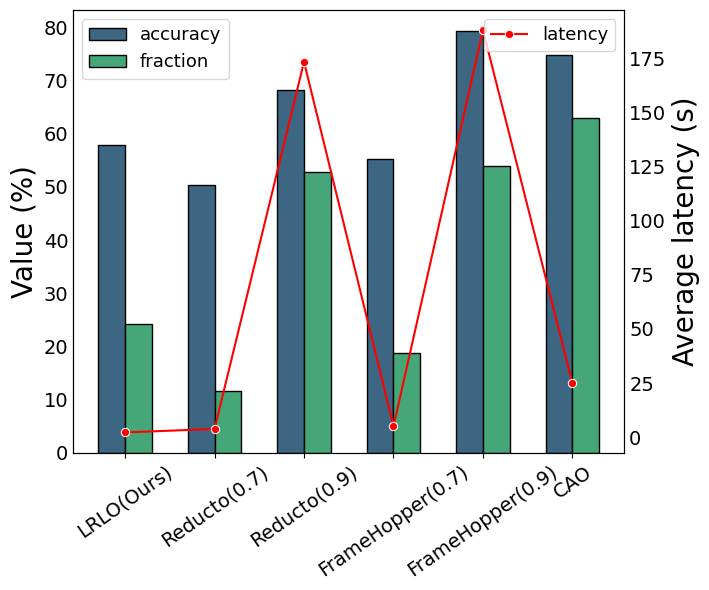

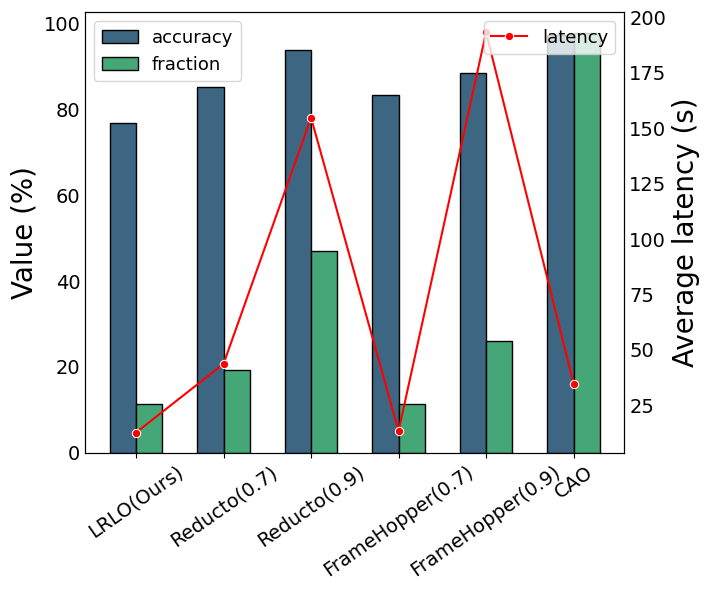

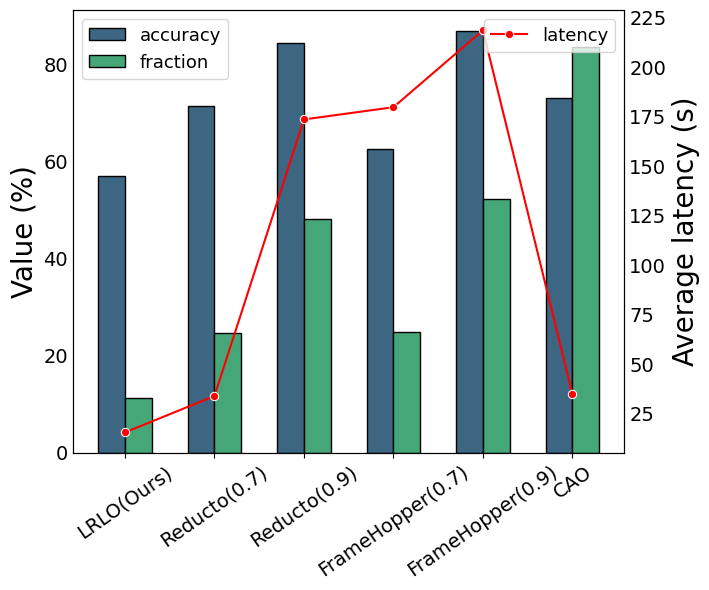

In [243]:
from matplotlib.ticker import FuncFormatter

legend_size = 13
axis_size = 14
label_size = 20

drop_df['method_with_target'] = drop_df.apply(
    lambda row: "LRLO(Ours)" if row['method'] == "LRLO" else (f"{row['method']}({row['target_f1']})" if not pd.isna(row['target_f1']) else row['method']),
    axis=1
)
drop_df.rename(columns={'f1_score': 'accuracy'}, inplace=True)
datasets = drop_df['dataset'].unique()

for dataset in datasets:
    subset = drop_df[drop_df['dataset'] == dataset]
    
    melted_df = subset.melt(id_vars=['method_with_target'], value_vars=['accuracy', 'fraction'], 
                            var_name='Metric', value_name='Value')

    fig, ax = plt.subplots(figsize=(7.2, 6))
    
    sns.barplot(data=melted_df, x='method_with_target', y='Value', hue='Metric', palette="viridis", ax=ax,  width=0.6, edgecolor='0')
    ax2 = ax.twinx()
    sns.lineplot(data=subset, x='method_with_target', y='latency', color="red", marker="o", label='latency', ax=ax2)

    # 축과 레이블 설정
    ax.set_xlabel('')
    ax.set_ylabel('Value (%)', fontsize=label_size)
    ax2.set_ylabel('Average latency (s)', fontsize=label_size)
    
    ax.tick_params(axis='x', rotation=35, labelsize=axis_size)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}'))  # 예: 0.1 -> 10
    
    # y축 tick 폰트 크기 조정
    ax.tick_params(axis='y', labelsize=axis_size, size=0, which='both')
    ax2.tick_params(axis='y', labelsize=axis_size, size=0, which='both') 

    # 범례 폰트 크기 조정
    ax.legend(loc='upper left', fontsize=legend_size)
    ax2.legend(loc='upper right', fontsize=legend_size)

    plt.tight_layout()
    plt.show()

### 2. [Frame Drop] Backlog Graph (코드 완성)

**2.1 backlog df 불러오기**

In [230]:
backlog_df_dict = {
    'JN': {
        'LRLO(Ours)': [],
        'Reducto(0.7)': None,
        'Reducto(0.9)': None,
        'FrameHopper(0.7)': None,
        'FrameHopper(0.9)': None,
        'CAO': None
    },
    'JK': {
        'LRLO(Ours)': [],
        'Reducto(0.7)': None,
        'Reducto(0.9)': None,
        'FrameHopper(0.7)': None,
        'FrameHopper(0.9)': None,
        'CAO': None
    },
    'SD': {
        'LRLO(Ours)': [],
        'Reducto(0.7)': None,
        'Reducto(0.9)': None,
        'FrameHopper(0.7)': None,
        'FrameHopper(0.9)': None,
        'CAO': None
    }
}

for dataset in datasets:
    for method in frame_drop_method_list:
        if method == 'CAO':
            backlog_path = f'{experiment_path}/frame_dropping/{method}_{dataset}/backlog/total_backlog.csv'
            df = get_backlog_exp(backlog_path)
            backlog_df_dict[dataset][method] = df
            
        else:
            base_dir = f'{experiment_path}/frame_dropping/{method}_{dataset}'
            subfolder_paths = [os.path.join(base_dir, name) for name in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, name))]
            
            for subfolder_path in subfolder_paths:
                backlog_path = f'{subfolder_path}/backlog/total_backlog.csv'
                df = get_backlog_exp(backlog_path)
                if method == 'LRLO':
                    backlog_df_dict[dataset][f'{method}(Ours)'].append(df)
                else:
                    backlog_df_dict[dataset][f'{method}({subfolder_path.split("_")[-3]})'] = df

In [231]:
print(backlog_df_dict['JN'].keys())
print(backlog_df_dict['JK'].keys())
print(backlog_df_dict['SD'].keys())

for dataset in dataset_list:
    none_items = {key: value for key, value in backlog_df_dict[dataset].items() if value is None}
    if none_items:
        print("Value가 None인 항목:", none_items)
    else:
        print("Value가 None인 항목이 없습니다.")

backlog_df_dict['JN']['LRLO(Ours)'][0]

dict_keys(['LRLO(Ours)', 'Reducto(0.7)', 'Reducto(0.9)', 'FrameHopper(0.7)', 'FrameHopper(0.9)', 'CAO'])
dict_keys(['LRLO(Ours)', 'Reducto(0.7)', 'Reducto(0.9)', 'FrameHopper(0.7)', 'FrameHopper(0.9)', 'CAO'])
dict_keys(['LRLO(Ours)', 'Reducto(0.7)', 'Reducto(0.9)', 'FrameHopper(0.7)', 'FrameHopper(0.9)', 'CAO'])
Value가 None인 항목이 없습니다.
Value가 None인 항목이 없습니다.
Value가 None인 항목이 없습니다.


,sum,avg
0,1.738903e+08,5.434071e+06
1,1.738899e+08,5.434060e+06
2,2.914237e+08,9.106991e+06
3,3.477821e+08,1.086819e+07
4,2.451353e+08,7.660478e+06
...,...,...
1177,0.000000e+00,0.000000e+00
1178,0.000000e+00,0.000000e+00
1179,0.000000e+00,0.000000e+00
1180,0.000000e+00,0.000000e+00


**2.2 backlog graph 그리기**

In [232]:
text_size = 18
label_size = 14
tick_size = 12


def smooth_data(data, window_size=5):
    return data.rolling(window=window_size, center=True).mean()


def plot_backlog_smoothed(data_dict, dataset_name, lrlo_index, scale_factor=0.1, time_limit=1000, window_size=5):
    # Check if the specified dataset exists
    if dataset_name not in data_dict:
        print(f"Dataset '{dataset_name}' not found in data dictionary.")
        return
    
    methods = data_dict[dataset_name]
    
    plt.figure(figsize=(7, 6))
    
    for method, df in methods.items():
        if df is not None:
            # Filter out 'Reducto(0.9)' and 'FrameHopper(0.9)' from plotting
            if method == 'Reducto(0.9)' or method == 'FrameHopper(0.9)':
                continue
            
            # Handle LRLO's specific element in the list
            if method == 'LRLO(Ours)' and isinstance(df, list):
                # Check if the specified LRLO index is within the list range
                if lrlo_index < len(df):
                    sub_df = df[lrlo_index]
                    sub_df = sub_df[sub_df.index <= time_limit]  # Limit to 0 to time_limit seconds
                    smoothed_sum = smooth_data(sub_df['avg'], window_size=window_size)
                    plt.plot(sub_df.index, smoothed_sum, label=f"{method}")
                else:
                    print(f"LRLO index {lrlo_index} is out of range for '{method}' in dataset '{dataset_name}'.")
                    return
            else:
                # For other methods, limit the time range and apply smoothing
                df = df[df.index <= time_limit]  # Limit to 0 to time_limit seconds
                smoothed_sum = smooth_data(df['avg'], window_size=window_size)
                plt.plot(df.index, smoothed_sum, label=method)
    
    plt.xlabel("Times", fontsize=text_size)
    plt.ylabel("Backlog (B)", fontsize=text_size)
    plt.legend(fontsize=label_size)
    plt.tick_params(axis='y', labelsize=tick_size, size=0, which='both')
    plt.tick_params(axis='x', labelsize=tick_size, size=0, which='both')
    plt.show()


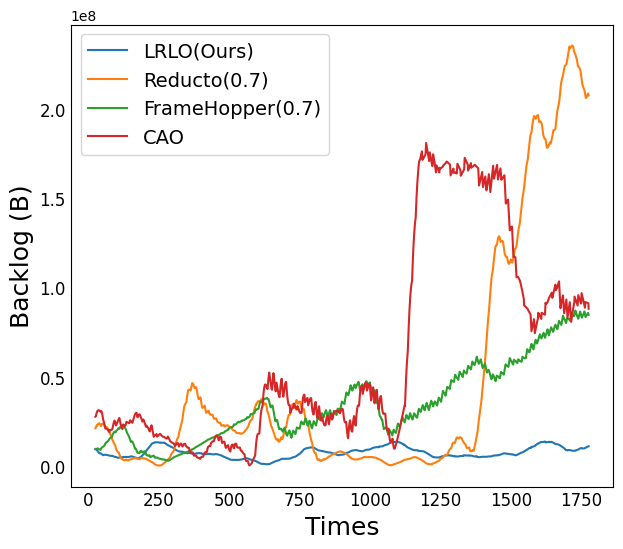

In [233]:
plot_backlog_smoothed(backlog_df_dict, 'JK', 2, scale_factor=0.1, time_limit=1800, window_size=50)

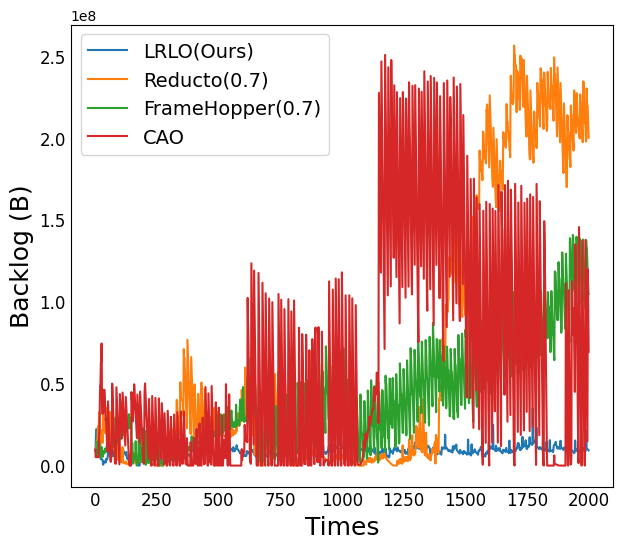

In [234]:
plot_backlog_smoothed(backlog_df_dict, 'JK', 3, scale_factor=0.1, time_limit=2000, window_size=2)

### 2. [Offloading] performance 비교 (코드 완성) *latency 분포를 그릴 수 있도록 수정...?

In [11]:
off_df = pd.read_csv(computation_offloading_summary_path, skipinitialspace=True)
off_df

,method,dataset,f1_score,fraction,latency,V
0,LRLO,JN,0.578711,0.2418,2.162152,1000000.0
1,LRLO,JK,0.768161,0.1131,12.572771,1000000.0
2,LRLO,SD,0.569505,0.1128,15.539509,1000000.0
3,JDPCRA,JN,0.755230,0.4901,74.040490,NaN
4,JDPCRA,JK,0.932370,0.6023,43.363060,NaN
5,JDPCRA,SD,0.815770,0.4001,37.282150,NaN
6,TLDOC,JN,0.755230,0.4901,28.460390,NaN
7,TLDOC,JK,0.932370,0.6023,26.514310,NaN
8,TLDOC,SD,0.815770,0.4001,28.694600,NaN


In [29]:
latency_df_dict = {
    'JN': {
        'LRLO': None,
        'JDPCRA': None,
        'TLDOC': None,
    },
    'JK': {
        'LRLO': None,
        'JDPCRA': None,
        'TLDOC': None,
    },
    'SD': {
        'LRLO': None,
        'JDPCRA': None,
        'TLDOC': None,
    }
}

for dataset in datasets:
    for method in computation_offloading_method_list:
        if method == 'LRLO':
            latency_path = f'{experiment_path}/computation_offloading/{method}_{dataset}/{method}/latency/test job 1.csv'
            df = get_latency_exp(latency_path)
            latency_df_dict[dataset]['LRLO'] = df
            
        else:
            latency_path = f'{experiment_path}/computation_offloading/{method}_{dataset}/latency/test job 1.csv'
            df = get_latency_exp(latency_path)
            latency_df_dict[dataset][method] = df

In [30]:
print(latency_df_dict['JN'].keys())
print(latency_df_dict['JK'].keys())
print(latency_df_dict['SD'].keys())

for dataset in dataset_list:
    none_items = {key: value for key, value in latency_df_dict[dataset].items() if value is None}
    if none_items:
        print("Value가 None인 항목:", none_items)
    else:
        print("Value가 None인 항목이 없습니다.")

latency_df_dict['JN']['LRLO']

dict_keys(['LRLO', 'JDPCRA', 'TLDOC'])
dict_keys(['LRLO', 'JDPCRA', 'TLDOC'])
dict_keys(['LRLO', 'JDPCRA', 'TLDOC'])
Value가 None인 항목이 없습니다.
Value가 None인 항목이 없습니다.
Value가 None인 항목이 없습니다.


,latency
0,863.094584
1,1177.087053
2,1282.951284
3,1556.151610
4,1538.336182
...,...
473,1381.594462
474,1449.976955
475,1471.025689
476,1982.224169


In [62]:
# axis_size = 13
# label_size = 15

# off_df['method'] = off_df['method'].replace('LRLO', 'LRLO(Ours)')
# datasets = off_df['dataset'].unique()

# for dataset in datasets:
#     subset = off_df[off_df['dataset'] == dataset]
    
#     melted_df = subset.melt(id_vars=['method'], value_vars=['f1_score', 'fraction'], 
#                             var_name='Metric', value_name='Value')

#     fig, ax = plt.subplots(figsize=(7.2, 6))
    
#     sns.barplot(data=melted_df, x='method', y='Value', hue='Metric', palette="viridis", ax=ax,  width=0.6, edgecolor='0')
#     ax2 = ax.twinx()
#     sns.lineplot(data=subset, x='method', y='latency', color="red", marker="o", label='latency', ax=ax2)

#     # 축과 레이블 설정
#     ax.set_xlabel('')
#     ax.set_ylabel('Value (%)', fontsize=label_size)
#     ax2.set_ylabel('Average latency (s)', fontsize=label_size)
    
#     ax.tick_params(axis='x', rotation=35, labelsize=axis_size)

#     ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}'))  # 예: 0.1 -> 10
    
#     # y축 tick 폰트 크기 조정
#     ax.tick_params(axis='y', labelsize=axis_size)  
#     ax2.tick_params(axis='y', labelsize=axis_size) 

#     # 범례 폰트 크기 조정
#     ax.legend(loc='upper left', fontsize=axis_size)
#     ax2.legend(loc='upper right', fontsize=axis_size)

#     plt.tight_layout()
#     plt.show()

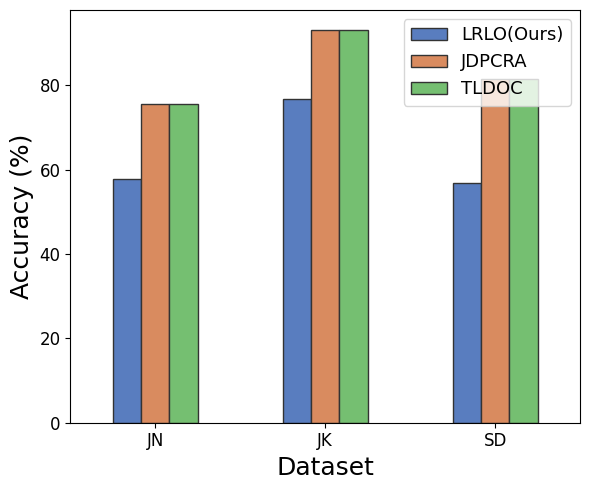

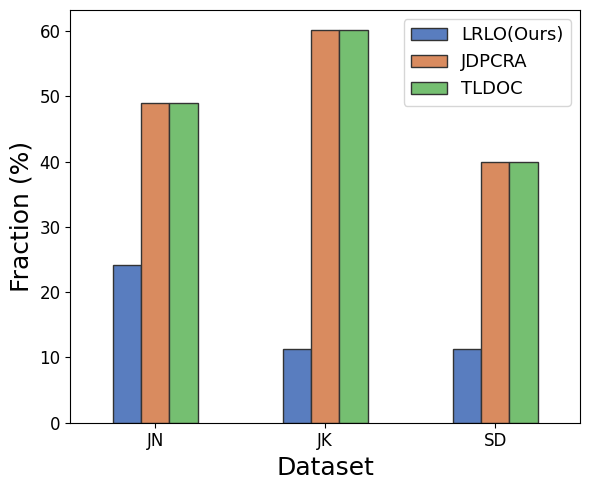

In [ ]:
text_size = 18
label_size = 13
tick_size = 12


metrics = ['f1_score', 'fraction']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Metric 데이터를 위한 막대 그래프 생성
    metric_df = off_df.melt(id_vars=['dataset', 'method'], value_vars=[metric], 
                            var_name='Metric', value_name='Value')
    
    sns.barplot(data=metric_df, x='dataset', y='Value', hue='method', ax=ax, edgecolor='0.2', width=0.5, palette='muted')
    
    ax.set_xlabel('Dataset', fontsize=text_size)
    if metric == 'f1_score':
        ax.set_ylabel('Accuracy (%)', fontsize=text_size)
    else:
        ax.set_ylabel('Fraction (%)', fontsize=text_size)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}'))  # 예: 0.1 -> 10
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    ax.legend(loc='upper right', fontsize=label_size)

    plt.tight_layout()
    plt.show()

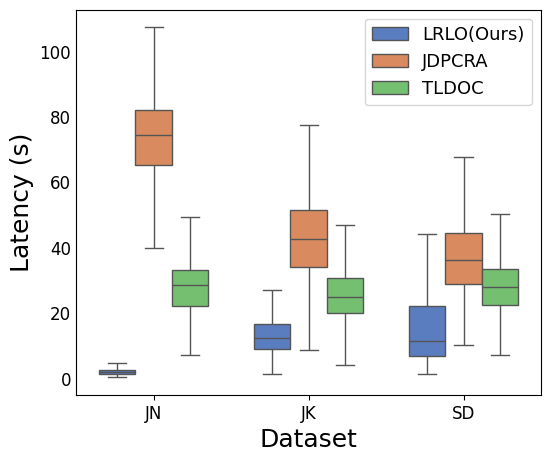

In [244]:
text_size = 18
label_size = 13
tick_size = 12

# Prepare data for plotting
plot_data = []

# print(latency_df_dict.items())
for dataset, methods in latency_df_dict.items():
    for method, df in methods.items():
        if df is not None:  # Ensure there is data
            if method == 'LRLO':
                method = 'LRLO(Ours)'
            for latency in df['latency'] / MS_TO_S:   
                plot_data.append({
                    'Dataset': dataset,
                    'Method': method,
                    'Latency (s)': latency
                })

# Convert to DataFrame for plotting
plot_df = pd.DataFrame(plot_data)

# print(plot_df)
# Plotting
plt.figure(figsize=(6, 5))
sns.boxplot(x='Dataset', y='Latency (s)', hue='Method', data=plot_df, palette="muted", width=0.7, showfliers=False, )
#plt.yscale('log')  # Using log scale for clarity if latency values vary widely
plt.xlabel('Dataset', fontsize=text_size)
plt.ylabel('Latency (s)', fontsize=text_size)
plt.tick_params(axis='x', labelsize=tick_size)
plt.tick_params(axis='y', labelsize=tick_size, size=0, which='both')
plt.legend(fontsize=label_size, loc='upper right')
plt.show()

### 4. [Offloading] Backlog (완성)

**4.1 data loading**

In [88]:
backlog_df_dict = {
    'JN': {
        'LRLO(Ours)': None,
        'JDPCRA': None,
        'TLDOC': None,
    },
    'JK': {
        'LRLO(Ours)': None,
        'JDPCRA': None,
        'TLDOC': None,
    },
    'SD': {
        'LRLO(Ours)': None,
        'JDPCRA': None,
        'TLDOC': None,
    }
}

for dataset in datasets:
    for method in computation_offloading_method_list:
        if method == 'LRLO':
            backlog_path = f'{experiment_path}/computation_offloading/{method}_{dataset}/{method}/backlog/total_backlog.csv'
            df = get_backlog_exp(backlog_path)
            backlog_df_dict[dataset]['LRLO(Ours)'] = df
            
        else:
            backlog_path = f'{experiment_path}/computation_offloading/{method}_{dataset}/backlog/total_backlog.csv'
            df = get_backlog_exp(backlog_path)
            backlog_df_dict[dataset][method] = df

In [218]:
text_size = 18
label_size = 14
tick_size = 12


def smooth_data(data, window_size=5):
    return data.rolling(window=window_size, center=True).mean()


def plot_backlog_smoothed_offloading(data_dict, dataset_name, time_limit=1000, window_size=5):
    # Check if the specified dataset exists
    if dataset_name not in data_dict:
        print(f"Dataset '{dataset_name}' not found in data dictionary.")
        return
    
    methods = data_dict[dataset_name]
    
    plt.figure(figsize=(7, 6))
    
    for method, df in methods.items():
        if df is not None:
            
            # For other methods, limit the time range and apply smoothing
            df = df[df.index <= time_limit]  # Limit to 0 to time_limit seconds
            smoothed_sum = smooth_data(df['avg'], window_size=window_size)
            #plt.plot(df.index, smoothed_sum, label=method)
            sns.lineplot(x=df.index, y=smoothed_sum, label=method, palette='muted')
    
    plt.xlabel("Times", fontsize=text_size)
    plt.ylabel("Backlog (B)", fontsize=text_size)
    plt.legend(fontsize=label_size, loc='upper right')
    plt.tick_params(axis='y', labelsize=tick_size, size=0, which='both')
    plt.tick_params(axis='x', labelsize=tick_size, size=0, which='both')
    plt.show()


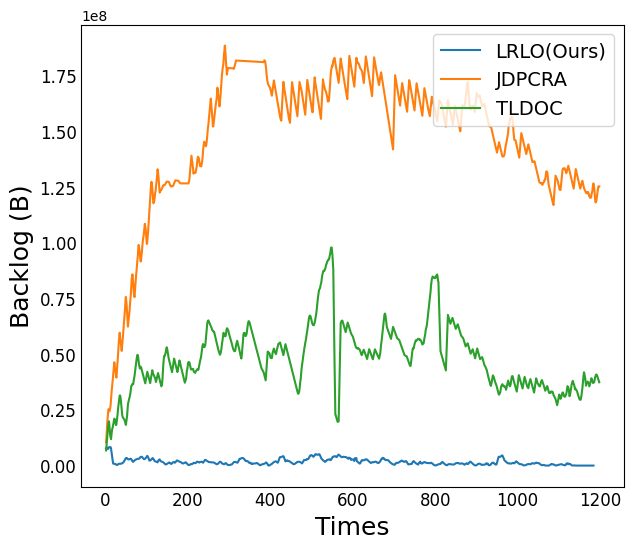

In [219]:
plot_backlog_smoothed_offloading(backlog_df_dict, 'JN', time_limit=1200, window_size=5)

### (수정) V에 따른 경향성 조사

In [203]:
exp_V_df = pd.read_csv(f'data/summary/V_value.csv', skipinitialspace=True)

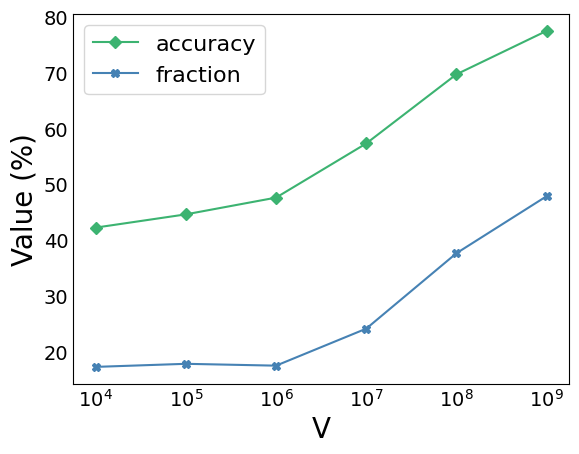

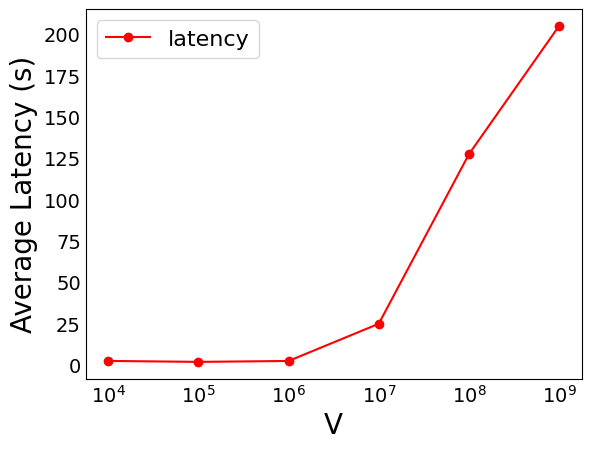

In [ ]:
plt.plot(exp_V_df['V'], exp_V_df['accuracy'], marker='D', label='accuracy', color="mediumseagreen")
plt.plot(exp_V_df['V'], exp_V_df['fraction'], marker='X', label='fraction', color="steelblue")

plt.xlabel('V', fontsize=20)
plt.ylabel('Value (%)', fontsize=20) 
plt.tick_params(labelsize=14, size=0, which="both") 
plt.legend(fontsize=15)
plt.xscale('log')
#ax2 = plt.gca().twinx()
#ax2.set_ylabel('Fraction') 
#plt.legend()
#plt.savefig(SAVE_ROOT+"effect_of_V_performance.pdf",  bbox_inches='tight', pad_inches=0)
plt.show()


plt.plot(exp_V_df['V'], exp_V_df['latency'], marker='o', color="red", label='latency')

plt.xlabel('V', fontsize=20)
plt.ylabel('Average Latency (s)', fontsize=20) 
plt.legend(fontsize=15, loc='best') 
plt.tick_params(labelsize=14, size=0, which="both") 
plt.xscale('log')
plt.grid(axis='x',linestyle='', linewidth=0)

#plt.savefig(SAVE_ROOT+"effect_of_V_latency.pdf",  bbox_inches='tight', pad_inches=0)
plt.show()
